In [2]:
from dcwetk.cwe_distance import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from frequency_grapher import *
import glob
from tqdm.notebook import tqdm
import pickle
import pandas as pd
from sklearn.cluster import AffinityPropagation

In [3]:
testTok = 'שונה'

In [4]:
embeddings = []
sents = []
pos = []
yrs = []

for name in tqdm(glob.glob('byp_docs_with_relational_embeddings/*.pickle')):
    yr = int(name[-11:-7])
    
    if 1880 <= yr <= 1950:
        with open(name, 'rb') as f:
            docs = pickle.load(f)
            f.close()
            
        for doc in docs:
            for sent in doc:
                for tok in sent:
                    for lem in tok:
                        if lem.lemma == testTok:
                            yrs.append(yr)
                            sents.append(str(sent))
                            pos.append(lem.pos_tag)
                            embeddings.append(lem.embedding)
                            
        del docs

  0%|          | 0/112 [00:00<?, ?it/s]

In [5]:
yrRange = [i for i in range(1880, 1950, 5)]
x, y = zip(*PCA(n_components=2).fit_transform(embeddings))
df = pd.DataFrame({'year': yrs, 'sents': sents, 'pos': pos, 'x': x, 'y': y})
labs = {'JJ': 0,
       'JJT': 1,
       'VB': 2,
       'BN': 3,
       'BNT': 4}
df['pos_labs'] = df['pos'].map(labs)

In [10]:
clusters = AffinityPropagation(random_state=10).fit_predict(embeddings)

In [11]:
df['clusters'] = clusters

mkdir: cannot create directory ‘embeddings_by_pos’: File exists
1880


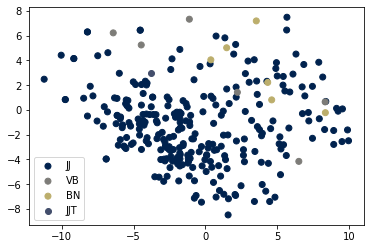

1885


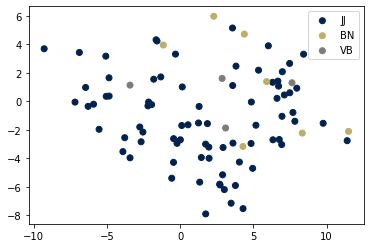

1890


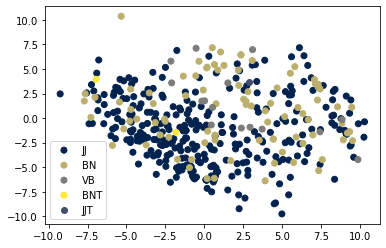

1895


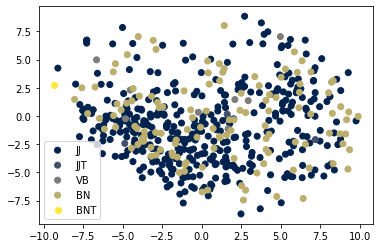

1900


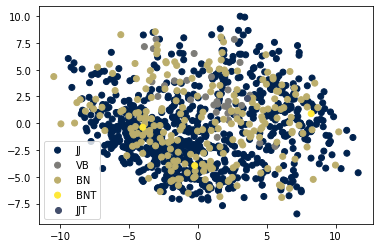

1905


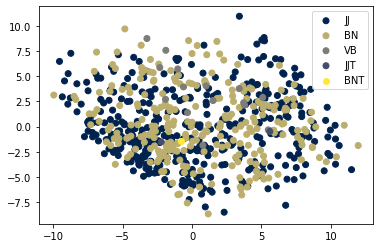

1910


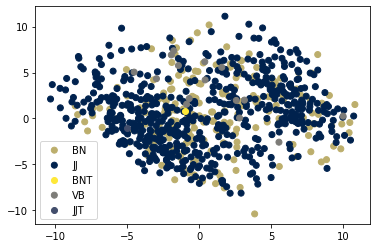

1915


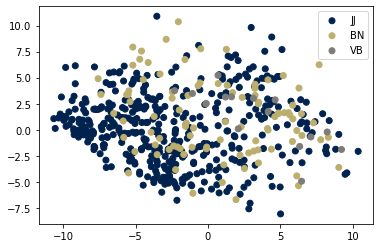

1920


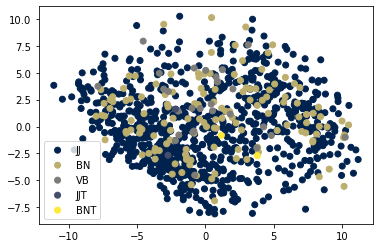

1925


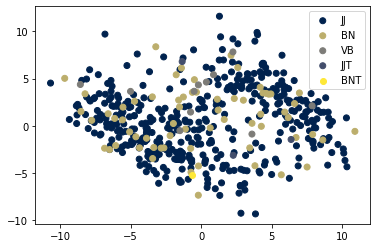

1930


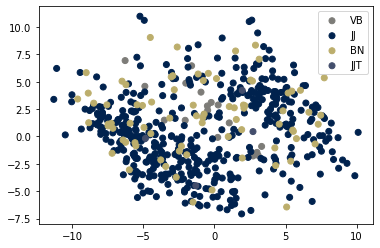

1935


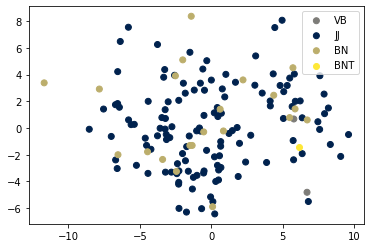

1940


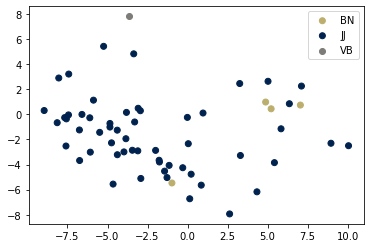

1945


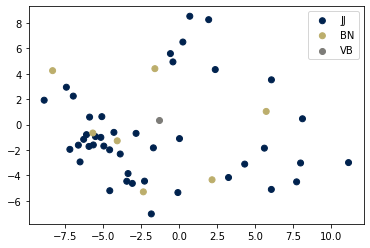

In [12]:
!mkdir embeddings_by_pos
labs = {'JJ': 0,
       'JJT': 1,
       'VB': 2,
       'BN': 3,
       'BNT': 4}
for yr in yrRange:
    prevYear = yr
    currYear = yr + 5
    tempDF = df[(df.year>=prevYear) & (df.year<currYear)]
    print(yr)
    fig, ax = plt.subplots()
    cmap = plt.cm.cividis
    norm = plt.Normalize(df['pos_labs'].values.min(), df['pos_labs'].values.max())
    
    for pos_cat in tempDF['pos'].unique():
        dff = tempDF[tempDF['pos'] == pos_cat]
        ax.scatter(dff.x, dff.y, c=cmap(norm(dff['pos_labs'])), label=pos_cat)
    # plt.scatter(tempDF.x, tempDF.y, c=tempDF.pos_labs, cmap='viridis')
    plt.legend()
    plt.savefig('embeddings_by_pos/' + testTok + '_' + str(prevYear) + '.png')
    plt.show()

In [24]:
# determine which clusters cluster the same parts of speech
pos_by_clusters_fine = {i: set() for i in df['clusters'].unique()}
for cl, pos in zip(df['clusters'].to_list(), df['pos'].to_list()):
    pos_by_clusters_fine[cl].add(pos)

df['pos_coarse'] = df['pos'].apply(lambda i: 'ADJ' if i in ['JJ', 'JJT'] else 'VB')
    
pos_by_clusters_coarse = {i: set() for i in df['clusters'].unique()}
for cl, pos in zip(df['clusters'].to_list(), df['pos_coarse'].to_list()):
    pos_by_clusters_coarse[cl].add(pos)
df['isHomogenous_fine'] = df['clusters'].apply(lambda i: True if len(pos_by_clusters_fine[i]) == 1 else False)
df['isHomogenous_coarse'] = df['clusters'].apply(lambda i: True if len(pos_by_clusters_coarse[i]) == 1 else False)

In [27]:
dfTrue_fine = df[df['isHomogenous_fine'] == True]
dfTrue_coarse = df[df['isHomogenous_coarse'] == True]
print(len(dfTrue_fine)/len(df))
print(len(dfTrue_coarse)/len(df))

0.18515775440675455
0.19345282180417717
